In [965]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
 
import re 
from string import punctuation
import nltk 
from nltk import word_tokenize
from nltk.tokenize import WordPunctTokenizer, PunktSentenceTokenizer
from nltk.corpus import wordnet, stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize.treebank import TreebankWordDetokenizer
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

import string
import os
import pickle

from textblob import Word

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score

from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Model, Sequential
from keras.layers import Input, Embedding, LSTM, Dense

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\43664\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\43664\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\43664\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\43664\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Read and inspect data

In [345]:
raw_train_data = pd.read_csv('train.csv')
raw_train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [96]:
raw_train_data.head(5)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [97]:
raw_train_data.dtypes

id               int64
qid1             int64
qid2             int64
question1       object
question2       object
is_duplicate     int64
dtype: object

In [4]:
### FOR LATER USE ##
#raw_test_data = pd.read_csv('test.csv')
#raw_test_data.head(5)

C:\Users\43664\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,2,What but is the best way to send money from Ch...,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?


In [98]:
print(raw_train_data.isnull().sum())

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64


In [5]:
#raw_test_data.isnull().sum()

test_id      0
question1    4
question2    6
dtype: int64

## Data Preparation

In [346]:
# Delete null/nan values
train_data = raw_train_data.dropna(axis=0)
#test_data = raw_test_data.dropna(axis=0)

In [100]:
train_data.isnull().sum()

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

In [9]:
test_data.isnull().sum()

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

In [347]:
#Drop id, qid1, qid2 columns
train_data = train_data.drop(['id', 'qid1', 'qid2'], axis=1)
train_data.head(5)

,question1,question2,is_duplicate
0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [104]:
train_data['question1'].iloc[0]

'What is the step by step guide to invest in share market in india?'

Value counts:
 0    255024
1    149263
Name: is_duplicate, dtype: int64

Percent of labels value:
 0    63.079941
1    36.920059
Name: is_duplicate, dtype: float64


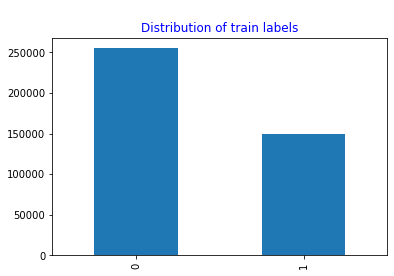

In [336]:
print('Value counts:\n', train_data['is_duplicate'].value_counts())
print('\nPercent of labels value:\n', train_data['is_duplicate'].value_counts()/train_data['is_duplicate'].count()*100)
train_data['is_duplicate'].value_counts().plot(kind = 'bar')
plt.title('\nDistribution of train labels', color = 'blue', size = 12)
plt.show()

Unique questions =  537933
Repeted questions =  111780


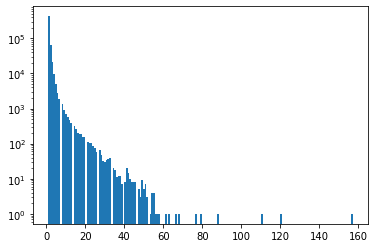

In [337]:
# repeated questions
qid = pd.Series(raw_train_data['qid1'].tolist() + raw_train_data['qid2'].tolist())
print('Unique questions = ', len(np.unique(qid)))
rep = qid.value_counts() > 1
print('Repeted questions = ', len(rep[rep]))
# reapeted ques hist
plt.hist(qid.value_counts().values, bins = 180)
plt.yscale('log')
plt.show()

max caracters =  623 
min caracters =  1 
average num of caracters =  59


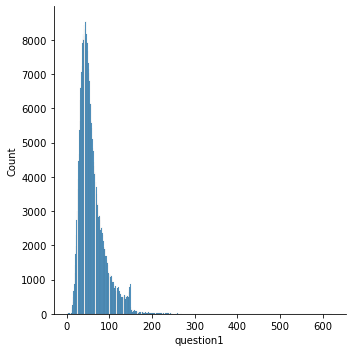

In [340]:
# analysis of features
q1_len = train_data['question1'].str.len()
sns.displot(q1_len)
print('max caracters = ', q1_len.max(), '\nmin caracters = ', q1_len.min(), '\naverage num of caracters = ', int(q1_len.mean()))

max caracters =  1169 
min caracters =  1 
average num of caracters =  60


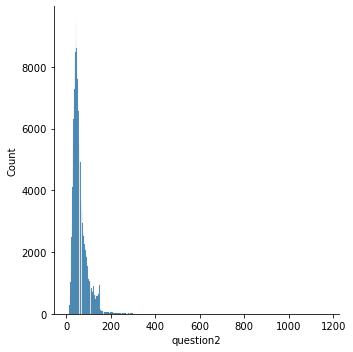

In [341]:
# analysis of features
q2_len = train_data['question2'].str.len()
sns.displot(q2_len)
print('max caracters = ', q2_len.max(), '\nmin caracters = ', q2_len.min(), '\naverage num of caracters = ', int(q2_len.mean()))

In [348]:
train_copy = train_data.copy()

## Text Preparation 
####  # before normalization # ##  

In [349]:
## REMOVE ACCENTED CHARACTERS Sómě Áccěntěd těxt ##
import unicodedata

def remove_accented_chars_func(text):
    return unicodedata.normalize('NFKD', str(text)).encode('ascii', 'ignore').decode('utf-8', 'ignore')

## REMOVE PUNCTUATION ##

def remove_punctuation_func(text):
    return re.sub(r'[^a-zA-Z0-9]', ' ', str(text))

## REMOVE IRRELEVANT CHARACTERS 

def remove_irr_char_func(text):
    return re.sub(r'[^a-zA-Z]', ' ', str(text))

## REMOVE EXTRA WHITESPACEs ##

def remove_extra_whitespaces_func(text):
    return re.sub(r'^\s*|\s\s*', ' ', str(text)).strip()

## COUNT OF STRINGS ##

def word_count_func(text):
    return len(str(text).split())

## REMOVE HASHTAG IN FRONT OF A TEXT##

def remove_hashtag(text):
    return re.sub(r'#([^\s]+)', r'\1', str(text))

In [350]:
train_copy['question1'] = train_copy['question1'].str.lower()
train_copy['question2'] = train_copy['question2'].str.lower()

train_copy['question1'] = train_copy['question1'].apply(remove_accented_chars_func)
train_copy['question2'] = train_copy['question2'].apply(remove_accented_chars_func)

train_copy['question1'] = train_copy['question1'].apply(remove_punctuation_func)
train_copy['question2'] = train_copy['question2'].apply(remove_punctuation_func)

train_copy['question1'] = train_copy['question1'].apply(remove_irr_char_func)
train_copy['question2'] = train_copy['question2'].apply(remove_irr_char_func)

train_copy['question1'] = train_copy['question1'].apply(remove_extra_whitespaces_func)
train_copy['question2'] = train_copy['question2'].apply(remove_extra_whitespaces_func)

train_copy['question1'] = train_copy['question1'].apply(remove_hashtag)
train_copy['question2'] = train_copy['question2'].apply(remove_hashtag)

train_copy.head(5)

,question1,question2,is_duplicate
0,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0
1,what is the story of kohinoor koh i noor diamond,what would happen if the indian government sto...,0
2,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0
3,why am i mentally very lonely how can i solve it,find the remainder when math math is divided by,0
4,which one dissolve in water quikly sugar salt ...,which fish would survive in salt water,0


## Copy of data

In [891]:
train_prep_copy = train_copy.copy()

## Split data

In [892]:
features = ['question1', 'question2']

X_data = train_prep_copy[features]
X_data.head()

,question1,question2
0,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...
1,what is the story of kohinoor koh i noor diamond,what would happen if the indian government sto...
2,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...
3,why am i mentally very lonely how can i solve it,find the remainder when math math is divided by
4,which one dissolve in water quikly sugar salt ...,which fish would survive in salt water


In [893]:
y_data = train_prep_copy['is_duplicate']
y_data.head(5)

0    0
1    0
2    0
3    0
4    0
Name: is_duplicate, dtype: int64

In [894]:
# Split the set into train and split data into 60/40, random_state 0 

### BIG TEST SIZE JUST TO TRY ###

from sklearn.model_selection import train_test_split
X_train, X_split, y_train, y_split = train_test_split(X_data, y_data, test_size=0.98, random_state = 0)  ## cambiar test size

print("Whole dataset: ", len(train_copy))
print("X_train size =", len(X_train))
print("X_split size =", len(X_split))
print("y_train size =", len(y_train))
print("y_split size =", len(y_split))

Whole dataset:  404287
X_train size = 8085
X_split size = 396202
y_train size = 8085
y_split size = 396202


In [895]:
# Split the set into test and validation into 50/50 (from 40% of the splitted data), random_state 0

### BIG TEST SIZE JUST TO TRY ###

from sklearn.model_selection import train_test_split
X_test, X_val, y_test, y_val = train_test_split(X_split, y_split, test_size=0.98, random_state = 0)

print("Whole dataset: ", len(train_copy))
print("X_test size =", len(X_test))
print("X_val size =", len(X_val))
print("y_test size =", len(y_test))
print("y_val size =", len(y_val))

Whole dataset:  404287
X_test size = 7924
X_val size = 388278
y_test size = 7924
y_val size = 388278


In [865]:
X_train.head(5)

,question1,question2
402536,should i learn objective c or swift in,what should i start to learn first objective c...
214168,what are the current technology trends,what are the current technologies
365613,do animals other than humans laugh,besides humans do any animals shed tears when ...
242265,why does my cat lick my other cat but not me,should i lick my cat
266543,what are some good dual identity movies,do you remember movies that you didn t like


In [896]:
y_train = pd.DataFrame(y_train, columns=['is_duplicate'])
X_train = X_train.join(y_train, lsuffix='_left', rsuffix='_right')
X_train

,question1,question2,is_duplicate
402536,should i learn objective c or swift in,what should i start to learn first objective c...,1
214168,what are the current technology trends,what are the current technologies,1
365613,do animals other than humans laugh,besides humans do any animals shed tears when ...,0
242265,why does my cat lick my other cat but not me,should i lick my cat,0
266543,what are some good dual identity movies,do you remember movies that you didn t like,0
...,...,...,...
359785,what are java and android,what is r java in android,0
358085,what is the proper length for men s pants,what is the proper length for men s suit pants,0
152316,how do i know whether i want to do mbbs or som...,how do i know if i really want to become a doctor,1
117953,how can i hack the snapchat chat history,what do you do to spy on snapchat chat history,1


In [927]:
y_test = pd.DataFrame(y_test, columns=['is_duplicate'])
X_test = X_test.join(y_test, lsuffix='_left', rsuffix='_right')
X_test

,question1,question2,is_duplicate
255343,what is tdr in construction how does it work,can we file tdr after train left,0
293330,what are the positive effects if any of long t...,what are the negative effects if any of long t...,0
274408,does watching a streamed video consume less da...,how can i download full videos,0
219792,what do guys really think about inexperienced ...,do men like inexperienced women,0
16869,will china disintegrate,when will china disintegrate like ussr,1
...,...,...,...
318307,where can i get funding for my idea,how do i get seed funding pre product,1
87313,top question that ask your coo when you plan a...,did anyone else feel compelled to ask a random...,0
359441,what would a socially conservative and fiscall...,were the dixiecrats fiscally liberal,0
319994,why do so many people not like jazz,how are many non korean people addicted to kpop,0


In [897]:
y_val = pd.DataFrame(y_val, columns=['is_duplicate'])
X_val = X_val.join(y_val, lsuffix='_left', rsuffix='_right')
X_val

,question1,question2,is_duplicate
109919,how do you feel about music,what do you feel about music,1
83078,what quora mean,contains multiple questions what is the meanin...,0
175157,how will the gst bill affect common men and th...,what exactly is gst bill and how exactly will ...,1
150497,what are some contradictions in the holy bible,why would god send down another holy book when...,0
345626,what percentage does direct and indirect tax a...,how tax calculated in india is it based on pro...,0
...,...,...,...
75524,are there asian jews,why did the nazis hate jewish people to the po...,0
382814,what part of the brain is responsible for reading,what part of the brain is responsible for desire,0
348319,is the flying spaghetti monster real,does the flying spaghetti monster exist,1
384716,which is the nickname for bmw bimmer or beamer,why is pepe a nickname for jose,0


In [1132]:
X_train_copy = X_train.copy()
X_test_copy = X_test.copy()
X_val_copy = X_val.copy()

## Text Normalization

In [631]:
## LOWER CASE ##
def lower_case(text): 
    return text.map(lambda m:m.lower())


## REMOVE STOP WORDS IF TEXT IS NOT TOKENIZED ##
stop = nltk.corpus.stopwords.words('english')
def eng_stopwords(text):
    return text.apply(lambda x: " ".join(x for x in x.split() if x not in stop)) 


## REMOVE STOPS IF TEXT IS TOKENIZED ##
def eng_stopwords_tokenized(text):
    return text.apply(lambda x: [item for item in x if item not in stop])

## TOKENIZATION ##
def tokenization(text):
    tokens = re.split(' ',text)
    return tokens
def token(text):
    text = text.apply(lambda x: tokenization(x))
    return text

## DETOKENIZE ##
def detoken(text):
    return text.apply(lambda x: TreebankWordDetokenizer().detokenize(x))


## LEMMATIZATION IF TEXT IS TOKENIZED ##
lemmatizer = WordNetLemmatizer()
def lemma_tokenized(text):
    text = text.apply(lambda x: [lemmatizer.lemmatize(item) for item in x])
    return text

## LEMMATIZATION IF TEXT IS NOT TOKENIZED ##
def lemma(text):
    return text.apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()])) 


## STEMMING IF TEXT IS NOT TOKENIZED ##
st = PorterStemmer() 
def stemming(text):
    return text.apply(lambda x: " ".join([st.stem(word) for word in x.split()]))


## STEMMING IF TEXT IS TOKENIZED ##
def stemming_tokenized(text):
    return text.apply(lambda x: [st.stem(item) for item in x])

## REMOVE SPACES ##
def replace_spaces(x,space,second):
    result = x.replace(space, second)
    return result

def remove_space(text):
    return text.apply(lambda x: replace_spaces(x, ' ', ' '))

## REMOVE SINGLE LETTERS IF TEXT IS TOKENIZED ##
def remove_single_letters(text):
    return text.apply(lambda x: [item for item in x if len(item) > 1])

In [ ]:
#with lemma example of animals = animal
# with stemming animals = anim

## Activate functions for X_train_copy

In [699]:
X_train_copy['question1'] = X_train_copy['question1'].pipe(lower_case)
X_train_copy['question2'] = X_train_copy['question2'].pipe(lower_case)

In [1133]:
X_train_copy['question1'] = X_train_copy['question1'].pipe(eng_stopwords)
X_train_copy['question2'] = X_train_copy['question2'].pipe(eng_stopwords)

In [1118]:
X_train_copy['question1'] = X_train_copy['question1'].pipe(token) 
X_train_copy['question2'] = X_train_copy['question2'].pipe(token)

In [674]:
X_train_copy['question1'] = X_train_copy['question1'].pipe(detoken) 
X_train_copy['question2'] = X_train_copy['question2'].pipe(detoken)

In [1119]:
X_train_copy['question1'] = X_train_copy['question1'].pipe(eng_stopwords_tokenized) 
X_train_copy['question2'] = X_train_copy['question2'].pipe(eng_stopwords_tokenized) 

In [680]:
X_train_copy['question1'] = X_train_copy['question1'].pipe(remove_single_letters)
X_train_copy['question2'] = X_train_copy['question2'].pipe(remove_single_letters)

In [882]:
X_train_copy['question1'] = X_train_copy['question1'].pipe(stemming) 
X_train_copy['question2'] = X_train_copy['question2'].pipe(stemming)

In [ ]:
X_train_copy['question1'] = X_train_copy['question1'].pipe(stemming_tokenized) 
X_train_copy['question2'] = X_train_copy['question2'].pipe(stemming_tokenized)

In [1134]:
X_train_copy['question1'] = X_train_copy['question1'].pipe(lemma) 
X_train_copy['question2'] = X_train_copy['question2'].pipe(lemma)

In [702]:
X_train_copy['question1'] = X_train_copy['question1'].pipe(lemma_tokenized) 
X_train_copy['question2'] = X_train_copy['question2'].pipe(lemma_tokenized)

In [675]:
X_train_copy['question1'] = X_train_copy['question1'].pipe(remove_space)
X_train_copy['question2'] = X_train_copy['question2'].pipe(remove_space)

In [668]:
X_train_copy.head(20)

,question1,question2
402536,"[learn, objective, swift]","[start, learn, first, objective, swift]"
214168,"[current, technology, trend]","[current, technology]"
365613,"[animal, human, laugh]","[besides, human, animal, shed, tear, cry]"
242265,"[cat, lick, cat]","[lick, cat]"
266543,"[good, dual, identity, movie]","[remember, movie, like]"
174953,"[solution, puzzle]","[choose, answer, question, random, chance, cor..."
202733,"[people, support, hillary, clinton, even, thou...","[people, continue, vote, hillary, clinton, eve..."
266217,"[difference, cse, ise]","[difference, cse]"
195895,"[iiit, trivandrum]","[dth, best, trivandrum]"
219537,"[much, time, take, get, jio, sim, activated]","[much, time, jio, sim, take, get, activated]"


## Activate functions X_test_copy 

In [ ]:
X_test_copy['question1'] = X_test_copy['question1'].pipe(lower_case)
X_test_copy['question2'] = X_test_copy['question2'].pipe(lower_case)

In [931]:
X_test_copy['question1'] = X_test_copy['question1'].pipe(eng_stopwords)
X_test_copy['question2'] = X_test_copy['question2'].pipe(eng_stopwords)

In [ ]:
X_test_copy['question1'] = X_test_copy['question1'].pipe(token) 
X_test_copy['question2'] = X_test_copy['question2'].pipe(token)

In [ ]:
X_test_copy['question1'] = X_test_copy['question1'].pipe(detoken) 
X_test_copy['question2'] = X_test_copy['question2'].pipe(detoken)

In [ ]:
X_test_copy['question1'] = X_test_copy['question1'].pipe(eng_stopwords_tokenized) 
X_test_copy['question2'] = X_test_copy['question2'].pipe(eng_stopwords_tokenized) 

In [ ]:
X_test_copy['question1'] = X_test_copy['question1'].pipe(remove_single_letters)
X_test_copy['question2'] = X_test_copy['question2'].pipe(remove_single_letters)

In [ ]:
X_test_copy['question1'] = X_test_copy['question1'].pipe(stemming) 
X_test_copy['question2'] = X_test_copy['question2'].pipe(stemming)

In [ ]:
X_test_copy['question1'] = X_test_copy['question1'].pipe(stemming_tokenized) 
X_test_copy['question2'] = X_test_copy['question2'].pipe(stemming_tokenized)

In [932]:
X_test_copy['question1'] = X_test_copy['question1'].pipe(lemma) 
X_test_copy['question2'] = X_test_copy['question2'].pipe(lemma)

In [ ]:
X_test_copy['question1'] = X_test_copy['question1'].pipe(lemma_tokenized) 
X_test_copy['question2'] = X_test_copy['question2'].pipe(lemma_tokenized)

In [ ]:
X_test_copy['question1'] = X_test_copy['question1'].pipe(remove_space)
X_test_copy['question2'] = X_test_copy['question2'].pipe(remove_space)

In [930]:
X_test_copy

,question1,question2,is_duplicate
255343,what is tdr in construction how does it work,can we file tdr after train left,0
293330,what are the positive effects if any of long t...,what are the negative effects if any of long t...,0
274408,does watching a streamed video consume less da...,how can i download full videos,0
219792,what do guys really think about inexperienced ...,do men like inexperienced women,0
16869,will china disintegrate,when will china disintegrate like ussr,1
...,...,...,...
318307,where can i get funding for my idea,how do i get seed funding pre product,1
87313,top question that ask your coo when you plan a...,did anyone else feel compelled to ask a random...,0
359441,what would a socially conservative and fiscall...,were the dixiecrats fiscally liberal,0
319994,why do so many people not like jazz,how are many non korean people addicted to kpop,0


In [712]:
# df_q1 = pd.DataFrame(X_train_q1, columns=['question1'])
# df_q2 = pd.DataFrame(X_train_q2, columns=['question2'])
# train_df = df_q1.join(df_q2, lsuffix='_left', rsuffix='_right')
# train_df

## Labelling target variable

In [904]:
labels = preprocessing.LabelEncoder()
# Convert continous y values to categorical
y_train_cat= labels.fit_transform(y_train)
print(y_train_cat)

#y_val_cat = labels.fit_transform(y_val)
#print(y_val_cat)

y_test_cat = labels.fit_transform(y_test)
print(y_test_cat)

[1 1 0 ... 1 1 1]
[0 0 0 ... 0 0 1]


C:\Users\43664\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## Text to Features - Count Vectorizer

In [905]:
print(type(X_train_copy))
print(type(X_train_copy['question1']))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


In [906]:
from sklearn.feature_extraction.text import CountVectorizer

## X TRAIN QUESTION 1 ##

train_q1 = X_train_copy['question1']

vectorizer = CountVectorizer()

vectorizer.fit(train_q1) 
vector_train_q1 = vectorizer.transform(train_q1)

print(vectorizer.vocabulary_)
print(vector_train_q1.toarray())

{'learn': 4538, 'objective': 5520, 'swift': 7835, 'current': 1939, 'technology': 7953, 'trend': 8240, 'animal': 347, 'human': 3757, 'laugh': 4510, 'cat': 1250, 'lick': 4596, 'good': 3368, 'dual': 2450, 'identity': 3827, 'movie': 5216, 'solution': 7445, 'puzzle': 6406, 'people': 5870, 'support': 7787, 'hillary': 3654, 'clinton': 1504, 'even': 2766, 'though': 8065, 'take': 7889, 'money': 5173, 'corporation': 1793, 'difference': 2238, 'cse': 1908, 'ise': 4167, 'iiit': 3845, 'trivandrum': 8254, 'much': 5232, 'time': 8103, 'get': 3301, 'jio': 4267, 'sim': 7294, 'activated': 92, 'infinity': 3975, 'raised': 6477, 'power': 6137, 'bed': 771, 'plot': 6033, 'replace': 6691, 'lazy': 4523, 'older': 5574, 'employee': 2628, 'workplace': 8843, 'someone': 7457, 'never': 5397, 'met': 5017, 'intimate': 4094, 'donald': 2383, 'trump': 8264, 'game': 3235, 'like': 4609, 'infamous': 3969, 'xbox': 8882, 'big': 851, 'earth': 2502, 'looking': 4706, 'moon': 5182, 'scope': 7049, 'sm': 7382, 'marketing': 4863, 'age

In [907]:
from sklearn.feature_extraction.text import CountVectorizer

## X TRAIN QUESTION 2 ##

train_q2 = X_train_copy['question2']

vectorizer = CountVectorizer()

vectorizer.fit(train_q1) 
vector_train_q2 = vectorizer.transform(train_q2)

print(vectorizer.vocabulary_)
print(vector_train_q2.toarray())

{'learn': 4538, 'objective': 5520, 'swift': 7835, 'current': 1939, 'technology': 7953, 'trend': 8240, 'animal': 347, 'human': 3757, 'laugh': 4510, 'cat': 1250, 'lick': 4596, 'good': 3368, 'dual': 2450, 'identity': 3827, 'movie': 5216, 'solution': 7445, 'puzzle': 6406, 'people': 5870, 'support': 7787, 'hillary': 3654, 'clinton': 1504, 'even': 2766, 'though': 8065, 'take': 7889, 'money': 5173, 'corporation': 1793, 'difference': 2238, 'cse': 1908, 'ise': 4167, 'iiit': 3845, 'trivandrum': 8254, 'much': 5232, 'time': 8103, 'get': 3301, 'jio': 4267, 'sim': 7294, 'activated': 92, 'infinity': 3975, 'raised': 6477, 'power': 6137, 'bed': 771, 'plot': 6033, 'replace': 6691, 'lazy': 4523, 'older': 5574, 'employee': 2628, 'workplace': 8843, 'someone': 7457, 'never': 5397, 'met': 5017, 'intimate': 4094, 'donald': 2383, 'trump': 8264, 'game': 3235, 'like': 4609, 'infamous': 3969, 'xbox': 8882, 'big': 851, 'earth': 2502, 'looking': 4706, 'moon': 5182, 'scope': 7049, 'sm': 7382, 'marketing': 4863, 'age

In [262]:
from sklearn.feature_extraction.text import CountVectorizer

## X TEST QUESTION 1 ##

test_q1 = X_test['question1']

vectorizer = CountVectorizer()
vectorizer.fit(test_q1) 
vector_test_q1 = vectorizer.transform(test_q1)

print(vectorizer.vocabulary_)
print(vector_test_q1.toarray())

{'guy': 2809, 'realli': 5389, 'think': 6677, 'inexperienc': 3207, 'woman': 7358, 'china': 1168, 'disintegr': 1847, 'hardest': 2850, 'adjust': 96, 'make': 3894, 'visit': 7166, 'georgia': 2650, 'cost': 1485, 'start': 6278, 'global': 2682, 'cabl': 951, 'news': 4414, 'network': 4397, 'find': 2407, 'hyderabadi': 3056, 'biryani': 740, 'chennai': 1153, 'mani': 3926, 'engin': 2135, 'postmat': 5036, 'programm': 5155, 'quora': 5292, 'old': 4581, 'languag': 3624, 'ever': 2217, 'good': 2713, 'without': 7350, 'learn': 3673, 'scienc': 5794, 'much': 4276, 'progress': 5157, 'scientist': 5796, 'made': 3864, 'bring': 871, 'back': 520, 'dead': 1656, 'peopl': 4822, 'overcom': 4673, 'heroin': 2919, 'addict': 88, 'would': 7384, 'happen': 2841, 'earth': 2010, 'extra': 2284, 'moon': 4234, 'one': 4600, 'big': 713, 'phobo': 4882, 'english': 2138, 'word': 7365, 'use': 7039, 'convers': 1452, 'indian': 3191, 'rare': 5352, 'exampl': 2240, 'silli': 6005, 'bandz': 562, 'lose': 3809, 'belli': 662, 'fat': 2345, 'india'

In [264]:
from sklearn.feature_extraction.text import CountVectorizer

## X TEST QUESTION 2 ##

test_q2 = X_test['question2']

vectorizer = CountVectorizer()
vectorizer.fit(test_q2) 
vector_test_q2 = vectorizer.transform(test_q2)

print(vectorizer.vocabulary_)
print(vector_test_q2.toarray())

{'men': 3941, 'like': 3649, 'inexperienc': 3116, 'woman': 7013, 'china': 1117, 'disintegr': 1770, 'ussr': 6723, 'hardest': 2783, 'adjust': 88, 'make': 3792, 'visit': 6831, 'netherland': 4269, 'best': 643, 'site': 5788, 'read': 5187, 'dc': 1579, 'marvel': 3856, 'comic': 1254, 'free': 2454, 'cool': 1383, 'way': 6909, 'say': 5531, 'ye': 7079, 'love': 3729, 'hyderabad': 2978, 'hyderabadi': 2979, 'mani': 3816, 'engin': 2056, 'pas': 4625, 'everi': 2145, 'year': 7080, 'switzerland': 6208, 'ever': 2144, 'recogn': 5212, 'street': 6082, 'result': 5342, 'quora': 5119, 'popular': 4867, 'scienc': 5563, 'capabl': 954, 'bring': 836, 'dead': 1582, 'back': 499, 'life': 3638, 'quit': 5116, 'heroin': 2862, 'addict': 82, 'would': 7042, 'happen': 2775, 'earth': 1935, 'one': 4464, 'moon': 4122, 'approxim': 334, 'mark': 3839, 'score': 5571, 'get': 2573, 'rand': 5152, 'around': 368, 'srm': 5992, 'jee': 3336, 'scientolog': 5566, 'scriptur': 5585, 'mean': 3901, 'famili': 2247, 'good': 2640, 'group': 2705, 'they

In [908]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_similarity(vector_train_q1, vector_train_q2)


array([[0.77459667, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.81649658, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.51639778, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.36514837, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.75      ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.8660254 ]])

In [725]:
vector_train_q2[0:100]

<100x8959 sparse matrix of type '<class 'numpy.int64'>'
	with 480 stored elements in Compressed Sparse Row format>

## N-GRAMS

In [259]:
from textblob import TextBlob

train_q1 = X_train_copy['question1']

ngrams_train_q1 = TextBlob(str(train_q1)).ngrams(3)

#ngrams_train_q1

In [ ]:
from textblob import TextBlob

train_q2 = X_train_copy['question2']

ngrams_train_q2 = TextBlob(str(train_q2)).ngrams(3)

#textblob

In [ ]:
from textblob import TextBlob

test_q1 = X_test_copy['question1']

ngrams_test_q1 = TextBlob(str(test_q1)).ngrams(3)

#textblob

In [ ]:
from textblob import TextBlob

test_q2 = X_test_copy['question2']

ngrams_test_q2 = TextBlob(str(test_q2)).ngrams(3)

#textblob

## TF-IDF

In [943]:
from sklearn.feature_extraction.text import TfidfVectorizer

## X TRAIN QUESTION 1 ##
limit = 7924
X_train_limited = X_train_copy[0:limit]
train_q1 = X_train_limited['question1']
vectorizer = TfidfVectorizer()
tfidf_train_q1 = vectorizer.fit_transform(train_q1)

print(tfidf_train_q1.shape)
#print(vectorizer.vocabulary_)
#print(vectorizer.idf_)

(7924, 10049)


In [944]:
## X TRAIN QUESTION 2 ##
limit = 7924
X_train_limited = X_train_copy[0:limit]
train_q2 = X_train_limited['question2']

#train_q2 = X_train_copy['question2']
vectorizer = TfidfVectorizer()
tfidf_train_q2 = vectorizer.fit_transform(train_q2)

print(tfidf_train_q1.shape)
#print(vectorizer.vocabulary_)
#print(vectorizer.idf_)


(7924, 10049)


In [952]:
## X TEST QUESTION 1 ##

test_q1 = X_test_copy['question1']

vectorizer = TfidfVectorizer()

tfidf_test_q1 = vectorizer.fit_transform(test_q1)
print(tfidf_train_q1.shape)
#print(vectorizer.vocabulary_)
#print(vectorizer.idf_)

(7924, 10049)


In [955]:
## X TEST QUESTION 2 ##

limit = 7924
X_test_limited = X_test_copy[0:limit]
test_q2 = X_test_limited['question2']

#test_q2 = X_test_copy['question2']

vectorizer = TfidfVectorizer()

tfidf_test_q2 = vectorizer.fit_transform(test_q2)
print(tfidf_train_q2.shape)
#print(vectorizer.vocabulary_)
#print(vectorizer.idf_)

(8085, 9688)


In [917]:
tfidf_train_q2[1000]

<1x8532 sparse matrix of type '<class 'numpy.float64'>'
	with 3 stored elements in Compressed Sparse Row format>

## Cosine Similarity

In [727]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_similarity(vector_train_q1, vector_train_q2)

array([[0.77459667, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.81649658, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.51639778, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.36514837, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.75      ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.8660254 ]])

In [728]:
print(vector_train_q1.shape)
print(vector_train_q2.shape)

(8085, 8959)
(8085, 8959)


In [752]:
cv = CountVectorizer()
def bow_train(text):
    questions = list(text['question1']) + list(text['question2'])
    q1_arr, q2_arr = np.vsplit(cv.fit_transform(questions).toarray(), 2)
    temp_df1 = pd.DataFrame(q1_arr, index = text.index)
    temp_df2 = pd.DataFrame(q2_arr, index = text.index)
    X_BoW_train_df = pd.concat([temp_df1, temp_df2], axis = 1)
    X_BoW_train_df['is_duplicate'] = y_data
    return X_BoW_train_df

In [753]:
X_BoW_train_df = bow_train(X_test_copy)

X_BoW_train_df

,0,1,2,3,4,5,6,7,8,9,...,12973,12974,12975,12976,12977,12978,12979,12980,12981,is_duplicate
255343,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
293330,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
274408,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
219792,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16869,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
318307,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
87313,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
359441,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
319994,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [831]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_similarity(X_BoW_train_df, X_BoW_train_df)

array([[1.        , 0.05103104, 0.11470787, ..., 0.06454972, 0.        ,
        0.07216878],
       [0.05103104, 1.        , 0.04682929, ..., 0.10540926, 0.04950738,
        0.11785113],
       [0.11470787, 0.04682929, 1.        , ..., 0.        , 0.05564149,
        0.        ],
       ...,
       [0.06454972, 0.10540926, 0.        , ..., 1.        , 0.        ,
        0.0745356 ],
       [0.        , 0.04950738, 0.05564149, ..., 0.        , 1.        ,
        0.070014  ],
       [0.07216878, 0.11785113, 0.        , ..., 0.0745356 , 0.070014  ,
        1.        ]])

## Word Embeddings

In [1076]:
## 3. Word Embeddings ##

## X TRAIN QUESTION 1 ##

we_tokenizer = Tokenizer()
we_tokenizer.fit_on_texts(X_train_copy['question1'])

sequences_train_q1 = np.array(we_tokenizer.texts_to_sequences(X_train_copy['question1']))

#we_tokenizer.word_index

In [801]:
## X TRAIN QUESTION 2 ##
we_tokenizer = Tokenizer()
we_tokenizer.fit_on_texts(X_train_copy['question2'])

sequences_train_q2 = np.array(we_tokenizer.texts_to_sequences(X_train_copy['question2']))

C:\Users\43664\AppData\Local\Temp/ipykernel_7224/134835833.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sequences_train_q2 = np.array(we_tokenizer.texts_to_sequences(X_train_copy['question2']))


In [758]:
## X TEST QUESTION 1 #
we_tokenizer = Tokenizer()
we_tokenizer.fit_on_texts(X_test_copy['question1'])

sequences_test_q1 = np.array(we_tokenizer.texts_to_sequences(X_test_copy['question1']))

C:\Users\43664\AppData\Local\Temp/ipykernel_7224/1196504880.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sequences_test_q1 = np.array(we_tokenizer.texts_to_sequences(X_test_copy['question1']))


In [759]:
## X TEST QUESTION 2 #
we_tokenizer = Tokenizer()
we_tokenizer.fit_on_texts(X_test_copy['question2'])

sequences_test_q2 = np.array(we_tokenizer.texts_to_sequences(X_test_copy['question2']))

C:\Users\43664\AppData\Local\Temp/ipykernel_7224/3765194562.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sequences_test_q2 = np.array(we_tokenizer.texts_to_sequences(X_test_copy['question2']))


In [1085]:
## create dataframe with both sequences train question1 and question 2 
df_seq1 = pd.DataFrame(sequences_train_q1)
df_seq1 = df_seq1.rename({0:'question1'}, axis=1)
#df_seq2 = pd.DataFrame(sequences_train_q2)
#df_seq2 = df_seq2.rename({0:'question2'}, axis=1)
#df = pd.concat([df_seq1, df_seq2, X_train_copy['is_duplicate']], axis=1, join='inner')
#df = pd.concat([df, y_data], axis = 1, join='inner')
df = pd.concat([df_seq1, X_train_copy['is_duplicate']], axis=1, join='inner')
df


,question1,is_duplicate
43,"[2, 3, 1, 1654, 1441, 697, 60, 7, 698, 571]",0
106,"[4, 11, 4884, 2432]",0
111,"[2, 9, 15, 9, 44, 15, 455, 8, 127, 26, 34, 18,...",0
120,"[4, 9, 5, 73, 6, 159, 3, 758, 8, 68]",1
171,"[4, 5, 917, 17, 113]",0
...,...,...
7865,"[2, 11, 29, 150, 79, 302, 33, 73, 148, 100, 75...",0
7877,"[2, 11, 29, 310, 45, 399, 22, 4088, 10, 212, 2...",0
7997,"[16, 3, 6, 212, 359, 10126, 61, 214]",0
8012,"[4, 13, 5, 820, 3046, 820, 101]",1


In [1026]:
print(X_train_copy['question1'].shape)
print(df.shape)
print(X_train_copy['is_duplicate'].shape)
print(type(X_train_copy['is_duplicate']))
print(type(df_seq2))

(8085,)
(8085, 2)
(8085,)
<class 'pandas.core.series.Series'>
<class 'pandas.core.frame.DataFrame'>


In [1069]:
for i, l in enumerate(df):
    print("list",i,"is",type(l))

list 0 is <class 'str'>
list 1 is <class 'str'>
list 2 is <class 'str'>


In [1114]:
X_train_padded_question1 = pad_sequences(sequences_train_q1, maxlen=max_len)
print(X_train_padded.shape)
X_train_padded_question2 = pad_sequences(sequences_train_q2, maxlen=max_len)
print(X_train_padded.shape)
print(X_train_padded_q1)
print(X_train_padded_q2)

(8085, 30)
(8085, 30)
[[   0    0    0 ...   22 1965    8]
 [   0    0    0 ...  565  504 1433]
 [   0    0    0 ...  114  607 1966]
 ...
 [   0    0    0 ...   22  411  743]
 [   0    0    0 ...  502 1990  254]
 [   0    0    0 ... 1070    1   88]]
[[   0    0    0 ...  196   23 2408]
 [   0    0    0 ...    1  443 1258]
 [   0    0    0 ...   45   63 1665]
 ...
 [   0    0    0 ...   99    6  936]
 [   0    0    0 ...  623 1443  312]
 [   0    0    0 ...  874    1  103]]


In [1115]:
X_train_complete = X_train_padded_question1 + X_train_padded_question2
X_train_complete

array([[   0,    0,    0, ...,  218, 1988, 2416],
       [   0,    0,    0, ...,  566,  947, 2691],
       [   0,    0,    0, ...,  159,  670, 3631],
       ...,
       [   0,    0,    0, ...,  121,  417, 1679],
       [   0,    0,    0, ..., 1125, 3433,  566],
       [   0,    0,    0, ..., 1944,    2,  191]])

In [1103]:
def generate_NN_model(vocab_size: int, max_len: int, embedding_size: int):
  model = Sequential()
  model.add(Input(max_len))
  model.add(Embedding(input_dim = vocab_size, output_dim = embedding_size)) #TODO: load pretrained embeddings
  model.add(LSTM(100))
  model.add(Dense(1, activation='sigmoid'))

  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

model = generate_NN_model(vocab_size, max_len, embedding_size=50)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 50)            509400    
                                                                 
 lstm (LSTM)                 (None, 100)               60400     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 569,901
Trainable params: 569,901
Non-trainable params: 0
_________________________________________________________________


In [1112]:
model_history = model.fit(X_train_complete, X_train_copy['is_duplicate'], epochs=5, batch_size=64)

Epoch 1/5
127/127 [==============================] - 8s 62ms/step - loss: 0.1407 - accuracy: 0.9420
Epoch 2/5
127/127 [==============================] - 8s 61ms/step - loss: 0.1050 - accuracy: 0.9581
Epoch 3/5
127/127 [==============================] - 7s 59ms/step - loss: 0.0835 - accuracy: 0.9683
Epoch 4/5
127/127 [==============================] - 8s 61ms/step - loss: 0.0736 - accuracy: 0.9712
Epoch 5/5
127/127 [==============================] - 8s 63ms/step - loss: 0.0599 - accuracy: 0.9766


## Word2Vect 

In [185]:
import pandas as pd
import nltk
import string
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk import word_tokenize
from gensim.models import Word2Vec as w2v
from sklearn.decomposition import PCA


texto = train_df['question1']
w = w2v(texto, min_count=3, sg=1, window=7)

In [191]:
emb_df = (pd.DataFrame([w.wv.get_vector(str(n)) for n in w.wv.key_to_index], 
                      index = w.wv.key_to_index
                      )
         )
print(emb_df.shape)
print(emb_df.head())

(27, 100)
         0         1         2         3         4         5         6   \
  -0.091287 -0.072540 -0.029185  0.026408  0.032271 -0.062796  0.062260   
e -0.094987  0.062690  0.129342  0.055432  0.013969 -0.081130  0.019054   
a -0.000032  0.057786  0.138453  0.043806  0.066739 -0.034047  0.026830   
i -0.086419  0.121831  0.124967  0.075001  0.109001 -0.104479 -0.014833   
t -0.047169  0.073875  0.020529  0.009770  0.032301 -0.057570  0.109777   

         7         8         9   ...        90        91        92        93  \
   0.234716 -0.123655 -0.087230  ...  0.069744  0.034897  0.122269 -0.065650   
e  0.256550 -0.122640 -0.181302  ...  0.082262 -0.003926  0.040047 -0.082950   
a  0.146708 -0.068438 -0.155368  ...  0.140770  0.026645  0.082311 -0.029388   
i  0.302338 -0.078011 -0.120528  ...  0.078283  0.025193  0.085876 -0.087448   
t  0.262458 -0.168771 -0.208575  ...  0.081503 -0.007298  0.001039 -0.028981   

         94        95        96        97        98       

[]

<Figure size 432x288 with 0 Axes>

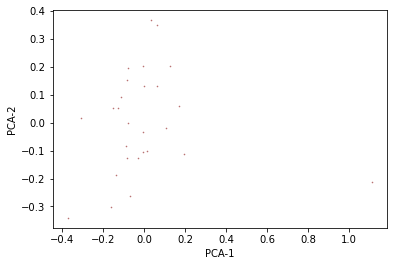

In [196]:
pca = PCA(n_components=2, random_state=7)
pca_mdl = pca.fit_transform(emb_df)

emb_df_PCA = (pd.DataFrame(
    pca_mdl, 
    columns=['x', 'y'], 
    index = emb_df.index))


plt.clf()
fig = plt.figure(figsize=(6, 4))

plt.scatter(x= emb_df_PCA['x'], 
            y=emb_df_PCA['y'],
            s = 0.4, 
            color = 'maroon', 
            alpha= 0.5
)

plt.xlabel('PCA-1')
plt.ylabel('PCA-2')
plt.plot()

In [202]:
train_df['question1']

0       begin take donald trump elected president thin...
1                              many legs butterflies used
2             true sweden largest number rape case europe
3                           revenue model socialtrade biz
4       net protector antivirus good comparison quickh...
                              ...                        
4037                                         java android
4038                              proper length men pants
4039                know whether want mbbs something else
4040                           hack snapchat chat history
4041                           social media changed world
Name: question1, Length: 4042, dtype: object

In [203]:
import gensim 
from gensim import corpora
dictionary = corpora.Dictionary(doc_clean)
doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
doc_term_matrix

[[(0, 1),
  (1, 1),
  (2, 1),
  (3, 1),
  (4, 1),
  (5, 1),
  (6, 2),
  (7, 1),
  (8, 1),
  (9, 1)],
 [(10, 1), (11, 1), (12, 1), (13, 1)],
 [(14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1)],
 [(21, 1), (22, 1), (23, 1), (24, 1)],
 [(4, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1)],
 [(4, 1), (32, 1), (33, 1), (34, 1), (35, 2), (36, 1), (37, 1), (38, 1)],
 [(39, 1), (40, 1), (41, 1), (42, 1)],
 [(43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1)],
 [(49, 1), (50, 1), (51, 1), (52, 1), (53, 1)],
 [(54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1)],
 [(61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1)],
 [(67, 1),
  (68, 1),
  (69, 1),
  (70, 1),
  (71, 1),
  (72, 1),
  (73, 1),
  (74, 1),
  (75, 1),
  (76, 1),
  (77, 1)],
 [(78, 1), (79, 1), (80, 1), (81, 1)],
 [(57, 1), (82, 1), (83, 1), (84, 1), (85, 1), (86, 1)],
 [(87, 1), (88, 1), (89, 1), (90, 1)],
 [(71, 1), (91, 1), (92, 1), (93, 1), (94, 1), (95, 1)],
 [(96, 1), (97, 1)],
 [(70

In [204]:
Lda = gensim.models.ldamodel.LdaModel

ldamodel = Lda(doc_term_matrix, num_topics=3, id2word=dictionary, passes=50)
print(ldamodel.print_topics())

[(0, '0.014*"many" + 0.012*"real" + 0.011*"one" + 0.010*"java" + 0.010*"like" + 0.010*"text" + 0.009*"better" + 0.009*"make" + 0.007*"university" + 0.007*"world"'), (1, '0.012*"nagar" + 0.010*"get" + 0.009*"life" + 0.009*"possible" + 0.009*"world" + 0.009*"food" + 0.009*"money" + 0.009*"time" + 0.008*"know" + 0.008*"people"'), (2, '0.020*"best" + 0.013*"quora" + 0.013*"india" + 0.010*"way" + 0.007*"difference" + 0.007*"learn" + 0.006*"people" + 0.006*"good" + 0.006*"woman" + 0.006*"using"')]


# Doc2Vec

In [1146]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

X_train_q1_tagged = [TaggedDocument(d, [i]) for i, d in enumerate(X_train_copy['question1'])]
#X_train_q2_tagged = [TaggedDocument(d, [i]) for i, d in enumerate(X_train_copy['question2'])]

In [1125]:
#X_train_tagged = X_train_q1_tagged + X_train_q2_tagged

In [1147]:
## TRAIN DOC2VEC MODEL ##

model_doc2vec = Doc2Vec(X_train_q1_tagged, vector_size =20, window=2, min_count=1, epochs=100)

model_doc2vec.wv.key_to_index

In [1139]:
test_doc_q2 = model_doc2vec.infer_vector(X_train_copy['question2'])

model_doc2vec.docvecs.most_similar(positive = [test_doc_q2])

[(4472, 0.6678565144538879),
 (3725, 0.6353070735931396),
 (4246, 0.625908374786377),
 (2519, 0.6005257368087769),
 (2657, 0.598753809928894),
 (7401, 0.592915415763855),
 (2567, 0.5902223587036133),
 (5028, 0.5874861478805542),
 (2297, 0.5838077664375305),
 (1636, 0.5820416212081909)]

In [1142]:
X_train_q1_tagged[4472]

TaggedDocument(words=['see', 'full', 'moon', 'earth', 'blocks', 'light', 'sun'], tags=[4472])

## BERT

In [1150]:
!pip install sentence-transformers


[notice] A new release of pip available: 22.1.2 -> 22.2.2
[notice] To update, run: python.exe -m pip install --upgrade pip


ERROR: Could not find a version that satisfies the requirement sentence-transformers (from versions: none)
ERROR: No matching distribution found for sentence-transformers


In [1161]:
pip install torch==1.2.0 torchvision==0.4.0


[notice] A new release of pip available: 22.1.2 -> 22.2.2
[notice] To update, run: python.exe -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement torch==1.2.0 (from versions: 1.7.1, 1.8.0, 1.8.1, 1.9.0, 1.9.1, 1.10.0, 1.10.1, 1.10.2, 1.11.0, 1.12.0, 1.12.1)
ERROR: No matching distribution found for torch==1.2.0


In [1162]:
pip install -e .

Obtaining file:///C:/Users/43664/MACHINE%20LEARNING/PROJECT%20ML

[notice] A new release of pip available: 22.1.2 -> 22.2.2
Note: you may need to restart the kernel to use updated packages.


ERROR: file:///C:/Users/43664/MACHINE%20LEARNING/PROJECT%20ML does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.


[notice] To update, run: python.exe -m pip install --upgrade pip


In [1152]:
from sentence_transformers import SentenceTransformer

#sbert_model = SentenceTransformer('bert-base-nli-mean-tokens')

ModuleNotFoundError: No module named 'sentence_transformers'

## Logistic Regression

In [948]:
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm

model = linear_model.LogisticRegression().fit(tfidf_train_q1, y_train)

In [951]:
print(y_test.shape)
print(y_train.shape)
limit = 7924
y_train = y_train[0:limit]
print(y_train.shape)
print(tfidf_test.shape)

(7924, 1)
(7924, 1)
(7924, 1)


NameError: name 'tfidf_test' is not defined

In [956]:
accuracy = metrics.accuracy_score(model.predict(tfidf_test_q1), y_test)  # en y_train realmente es y_val 
print ("Accuracy: ", accuracy) 
#Accuracy:  0.845048497186 
# Classification report 
print(metrics.classification_report(y_test, model.predict(tfidf_test_q1),target_names=train_copy['is_duplicate'].unique()))
#chequear en libro pag 125

ValueError: X has 8917 features, but LogisticRegression is expecting 10049 features as input.